# This sandbox creates the simulation environment

## Classes
1. Bus
2. Stop
3. Pax: with OD

In [255]:
import numpy as np
import pandas as pd
import matplotlib as plt

from IPython.display import display, clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [286]:
def read_data(filename, direction=0):
    """
    read stop and speed from data created by fetchbus.py
    """
    data = pd.read_csv(filename)
    
    # subset data for non-repeating stops
    data = data[data['DirectionRef'] == direction]
    data.drop_duplicates(['CallDistanceAlongRoute'], inplace=True)
    data.sort_values(['CallDistanceAlongRoute'], inplace=True)
    
    # read 1-D stop distances (in meters) and names
    stop_pos = np.array(data['CallDistanceAlongRoute'])
    stop_name = np.array(data['StopPointName'])
    
    stop_pos -= stop_pos[0] # reset first stop to 0 ### TEMPARARY MEASURE ###
    
    # read LTT or speed
    ### CURRENTLY UNAVAILABLE ###
    
    # read dwelling time
    ### CURRENTLY UNAVAILABLE ###
    
    return stop_pos, stop_name

In [317]:
# determine data source
beta = False
time_coef = 100000 # simulation time is __ times faster than the reality

if beta:
    # artificial data
    stop_pos = np.array([0, 100, 200, 300, 400, 500, 600])
    stop_name = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
else:
    # historical data
    stop_pos, stop_name = read_data("MTA_data/M1-Tue-180410-154415-260.csv", 1)

# speed and travel time data are currently artificial
link_vel = 1.5 * np.random.randn(len(stop_pos)) + 7 # make sure the unit is m/sec
dwell_t = 7 * np.random.randn(len(stop_pos)) + 20 # make sure the unit is sec

#dwell_t = 5 + 2 * 2 + 3 * 5 # door opening and closing + alight time * alight pax + board time * board pax

In [318]:
# Bus class
class Bus(object):
    
    capacity = 60
    seat = 40
    
    def __init__(self, ref, pos=0):
        self.ref = ref # vehicle reference
        self.pos = pos # vehicle location (1-D)
        self.link = np.sum(self.pos >= stop_pos) - 1 # link index starts from 0
        self.vel = link_vel[self.link] # speed at current link
        self.next_stop = stop_pos[self.link + 1] # position of next stop
        self.dwell_time = dwell_t[self.link + 1]
        self.pax = 0
        self.clock = 0
        self.operate = True
        self.init = True
        
        self.log_pos = [self.pos]
        self.log_vel = [self.vel]
        self.log_pax = [0]
        self.log_dwell = [0]

    def terminal(self):
        print("The bus has reached the terminal")
        self.operate = False
        self.vel = 0
        self.pax = 0
        
    def stop(self):
        print("Bus %s is making a stop at %s (position %i)"%(self.ref, stop_name[self.link + 1], self.next_stop))
        self.clock += 1
#         self.vel = 0
#         self.pos += self.vel
        self.record()

    def move(self):
        self.clock = 0
        self.link += 1
        self.pax = 0 # update pax onboard ###################
        self.record()
        self.log_dwell.append(self.dwell_time)
        self.vel = link_vel[self.link] # new link speed
        self.next_stop = stop_pos[self.link + 1] # new next stop
        self.dwell_time = dwell_t[self.link + 1]

    def record(self):
        self.log_pos.append(self.pos)
        self.log_pax.append(self.pax)
        
    def proceed(self):
        if self.operate:
            if self.pos + self.vel >= stop_pos[-1]:
                self.terminal()
            elif self.pos + self.vel >= self.next_stop:  ### this judgement restricts from recording vel as 0 at stop, change to sth else
                if self.clock >= self.dwell_time:
                    self.move()
                else:
                    self.stop()
            else:
                print("Current position of bus %s: %i"%(self.ref, self.pos))
                self.pos += self.vel
                self.record()
        else:
            print("Bus %s is not operating."%(self.ref))

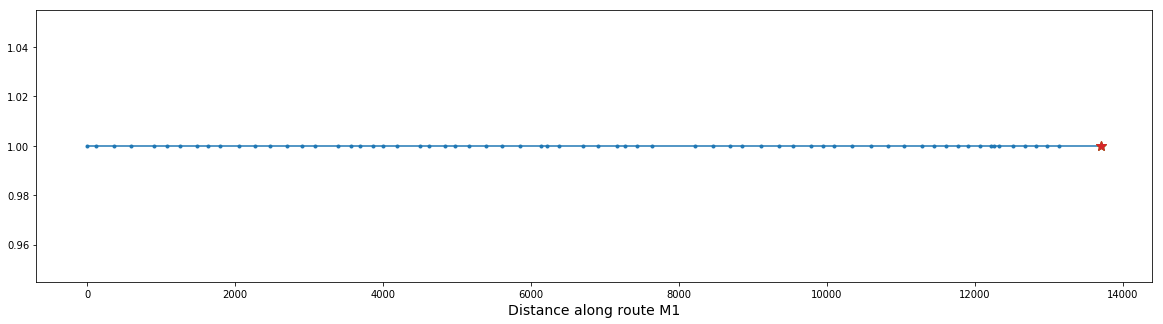

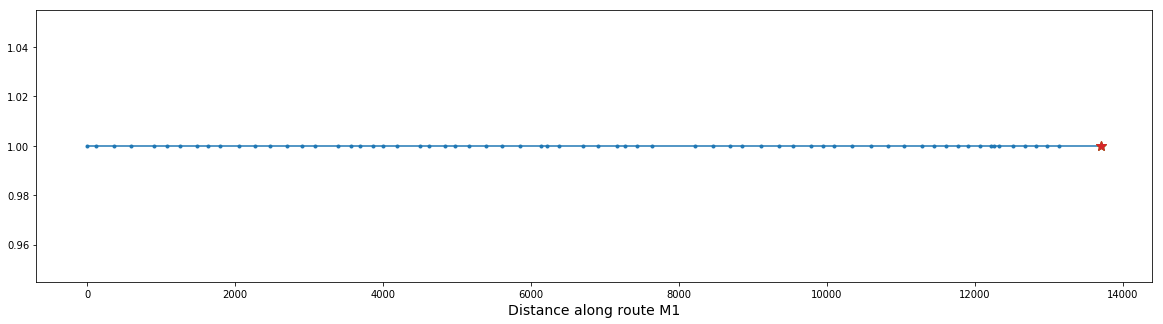

In [319]:
bus1 = Bus('7609', 0)
bus2 = Bus('7828', 1200)
bus3 = Bus('7964', 4500)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

### FLATTEN THE CODE HERE!!! ###
ax.plot(stop_pos, np.ones(len(stop_pos)), '.-')
veh1, = ax.plot(bus1.pos, 1, '*', markersize=10)
veh2, = ax.plot(bus2.pos, 1, '*', markersize=10)
veh3, = ax.plot(bus3.pos, 1, '*', markersize=10)

ax.set_xlabel('Distance along route M1', fontsize=14)

clock = 0
while bus1.operate or bus2.operate or bus3.operate:
    bus1.proceed()
    bus2.proceed()
    bus3.proceed()
    veh1.set_xdata(bus1.pos)
    veh2.set_xdata(bus2.pos)
    veh3.set_xdata(bus3.pos)
    clear_output(wait=True)
    display(fig)
    clock += 1
    time.sleep(1/time_coef) # set a global time equivalent parameter

# Next tasks
1. scale up: group generation given bus and stop data

In [ ]:
class Stop(object):
    def pax(self):
    def wait_time(self):
    def spacing(self):
    def stop_log(self):

In [ ]:
def pax_arrival(lamb):
    for stop in range(len(pax_vars)):
        if i == 0:
            df.loc[i,pax_vars[stop]] = 0
        else:
            df.loc[i,pax_vars[stop]] = df.loc[i-1,pax_vars[stop]] + numpy.random.poisson(lam=(lamb/3600),size=1)[0]

In [52]:
# rock_group = set()
# missile_group = set()

In [ ]:
def draw(canvas):
    global time, started, score, lives, rock_group, my_ships
 
    # animiate background
    time += 1
    center = debris_info.get_center()
    size = debris_info.get_size()
    wtime = (time / 8) % center[0]
    canvas.draw_image(nebula_image, nebula_info.get_center(),
                      nebula_info.get_size(), [WIDTH / 2, HEIGHT / 2],
                      [WIDTH, HEIGHT])
    canvas.draw_image(debris_image, [center[0] - wtime, center[1]],
                      [size[0] - 2 * wtime, size[1]],
                      [WIDTH / 2 + 1.25 * wtime, HEIGHT / 2],
                      [WIDTH - 2.5 * wtime, HEIGHT])
    canvas.draw_image(debris_image, [size[0] - wtime, center[1]],
                      [2 * wtime, size[1]], [1.25 * wtime, HEIGHT / 2],
                      [2.5 * wtime, HEIGHT])

    # increase rock's velocity using score
    for rock in rock_group:
        for i in range(2):
            rock.vel[i] = rock.init_vel[i] + (rock.init_vel[i] * score * 0.03)

    # draw ship and sprites
    my_ship.draw(canvas)
    my_ship.update()
    process_sprite_group(rock_group, canvas)
    process_sprite_group(missile_group, canvas)
    process_sprite_group(explosion_group, canvas)

    # process collisions
    if group_collide(rock_group, my_ship):
        lives -= 1
    score += group_group_collide(missile_group, rock_group) * 10

    # check game status
    if lives == 0:
        rock_group = set()
        started = False

    # draw UI
    canvas.draw_text("Lives", [50, 60], 30, "white")

    # draw splash screen if not started
    if not started:
        canvas.draw_image(splash_image, splash_info.get_center(),
                          splash_info.get_size(), [WIDTH / 2, HEIGHT / 2],
                          splash_info.get_size())


# timer handler that spawns a rock
def rock_spawner():
    global rock_group, started
    if len(rock_group) > 12 or not started:
        return
    rock_vel = [random.random() * .6 - .3, random.random() * .6 - .3]
    rock_avel = random.random() * .2 - .1
    rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
    # ensure rock_pos is at least 100px away of my_ship
    while dist(rock_pos, my_ship.pos) < 100:
        rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
    # add rock to the group
    rock_group.add(Sprite(rock_pos, rock_vel, 0, rock_avel,
                          asteroid_image, asteroid_info))

In [ ]:
def hello():
    print "hello, world"

t = Timer(30.0, hello)
t.start() # after 30 seconds, "hello, world" will be printed

In [ ]:
class Bus:
    __capacity = Max Passengers
    __passengers = {} # Key on the passenger name

# In your addPassenger method, you need to make sure you haven't reached your "capacity".
# If you have, raise an exception. Also ensure the parameter is type checked and only allows Passenger objects.

In [13]:
from IPython.display import HTML
HTML(ani.to_jshtml())

%matplotlib notebook
import matplotlib.animation

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
